In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [2]:
LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 28 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)

VALID = 10000 # Validation data size

STEPS = 20000 #20000   # Number of steps to run
BATCH = 100 # Stochastic Gradient Descent batch size
PATCH = 5 # Convolutional Kernel size
DEPTH = 8 #32 # Convolutional Kernel depth size == Number of Convolutional Kernels
HIDDEN = 100 #1024 # Number of hidden neurons in the fully connected layer

LR = 0.001 # Learning rate

In [3]:
data = pd.read_csv('Mnist_Data1/train.csv') # Read csv file in pandas dataframe
labels = np.array(data.pop('label')) # Remove the labels as a numpy array from the dataframe
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()
data = StandardScaler().fit_transform(np.float32(data.values)) # Convert the dataframe to a numpy array
data = data/255 # Its good to normalize pixel values.
data = data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images
train_data, valid_data = data[:-VALID], data[-VALID:]
train_labels, valid_labels = labels[:-VALID], labels[-VALID:]

print('train data shape = ' + str(train_data.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(labels.shape) + ' = (TRAIN, LABELS)')
data

train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)


array([[[[  0.00000000e+00],
         [  0.00000000e+00],
         [  0.00000000e+00],
         ..., 
         [  0.00000000e+00],
         [  0.00000000e+00],
         [  0.00000000e+00]],

        [[  0.00000000e+00],
         [  0.00000000e+00],
         [  0.00000000e+00],
         ..., 
         [  0.00000000e+00],
         [  0.00000000e+00],
         [  0.00000000e+00]],

        [[  0.00000000e+00],
         [  0.00000000e+00],
         [ -1.91355211e-05],
         ..., 
         [ -3.15960388e-05],
         [  0.00000000e+00],
         [  0.00000000e+00]],

        ..., 
        [[  0.00000000e+00],
         [  0.00000000e+00],
         [ -3.12370139e-05],
         ..., 
         [ -2.66013139e-05],
         [ -1.91355248e-05],
         [  0.00000000e+00]],

        [[  0.00000000e+00],
         [  0.00000000e+00],
         [  0.00000000e+00],
         ..., 
         [ -1.91355230e-05],
         [  0.00000000e+00],
         [  0.00000000e+00]],

        [[  0.00000000e+00],
  

In [4]:
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))

In [5]:
w1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b1 = tf.Variable(tf.zeros([32]))
w2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[64]))
w3 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[1024]))
w4 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[10]))
keep_prob=tf.placeholder(tf.float32)


def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    x = tf.nn.dropout(x, keep_prob)
    # Fully connected layer
    x = tf.reshape(x, (-1, 7*7*64))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4

# Prediction:
tf_pred = tf.nn.softmax(logits(tf_data))

In [6]:
 logits(tf_data)

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

In [7]:
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), 
                                                                 labels=tf_labels))
tf_acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

#tf_opt = tf.train.GradientDescentOptimizer(LR)
tf_opt = tf.train.AdamOptimizer(LR)
#tf_opt = tf.train.RMSPropOptimizer(LR)
tf_step = tf_opt.minimize(tf_loss)

In [8]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

In [9]:
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx],keep_prob:0.5}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
            fd = {tf_data:valid_data, tf_labels:valid_labels,keep_prob:1.0}
            valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
            history.append((step, valid_loss, valid_accuracy))
            print('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 86.239998
Step 1000 	 Valid. Acc. = 95.080017
Step 1500 	 Valid. Acc. = 96.080002
Step 2000 	 Valid. Acc. = 96.760017
Step 2500 	 Valid. Acc. = 97.140015
Step 3000 	 Valid. Acc. = 97.440018
Step 3500 	 Valid. Acc. = 97.520004
Step 4000 	 Valid. Acc. = 98.010010
Step 4500 	 Valid. Acc. = 98.320007
Step 5000 	 Valid. Acc. = 98.280014
Step 5500 	 Valid. Acc. = 98.530022
Step 6000 	 Valid. Acc. = 98.410011
Step 6500 	 Valid. Acc. = 98.360016
Step 7000 	 Valid. Acc. = 98.530014
Step 7500 	 Valid. Acc. = 98.460022
Step 8000 	 Valid. Acc. = 98.490013
Step 8500 	 Valid. Acc. = 98.260017
Step 9000 	 Valid. Acc. = 98.650017
Step 9500 	 Valid. Acc. = 98.800011
Step 10000 	 Valid. Acc. = 98.600021
Step 10500 	 Valid. Acc. = 98.710014
Step 11000 	 Valid. Acc. = 98.770020
Step 11500 	 Valid. Acc. = 98.700020
Step 12000 	 Valid. Acc. = 98.830017
Step 12500 	 Valid. Acc. = 98.740005
Step 13000 	 Valid. Acc. = 98.580017
Step 13500 	 Valid. Acc. = 98.770020
Step 14000 	 Valid. A

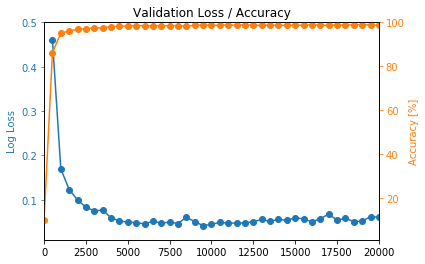

In [10]:
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 0.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)

plt.show()

In [13]:
test = pd.read_csv('Mnist_Data1/test.csv') # Read csv file in pandas dataframe
test_data = StandardScaler().fit_transform(np.float32(test.values)) # Convert the dataframe to a numpy array
test_data = test_data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images

In [14]:
test_pred = session.run(tf_pred, feed_dict={tf_data:test_data, keep_prob:1.0})
test_labels = np.argmax(test_pred, axis=1)

In [15]:
test_labels

array([2, 0, 9, ..., 3, 9, 2])

In [16]:
submission = pd.DataFrame(data={'ImageId':(np.arange(test_labels.shape[0])+1), 'Label':test_labels})
submission.to_csv('submission.csv', index=False)
submission.tail()


,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2
